# Simulación de Arribos de Aviones a AEP

Este notebook contiene la resolución de los problemas planteados sobre simulación de arribos de aviones mediante métodos de Monte Carlo.  
Incluye experimentos con distintos valores de λ, análisis de congestión, desvíos y posibles políticas de control de tráfico aéreo.  

---
# Simulación de Arribos de Aviones a AEP

Este notebook contiene la resolución de los problemas planteados sobre simulación de arribos de aviones mediante métodos de Monte Carlo.  
Incluye experimentos con distintos valores de λ, análisis de congestión, desvíos y posibles políticas de control de tráfico aéreo.  

---

## 0. Setup de la simulación

En esta sección se definen:  
- Parámetros globales (velocidades, distancias, tiempos).  
- Funciones auxiliares (generar arribos, simular dinámica, métricas, visualización).  
- Una función principal `simular(...)` que permita correr la simulación variando λ y otras condiciones.  
De este modo, el resto de las secciones solo necesitan llamar a estas funciones.

In [1]:
from Depenedencias import (Avion,Fila, random, np, 
                           DISTANCIA_INICIAL, VEL_MARCHA_ATRAS, GAP_MIN, GAP_BUFFER,GAP_REINSERCION,DT, 
                           generar_vuelos_poisson, crear_aviones, inicializar_resultados, debug_avion, filtrar_aviones_a_tiempo, avanzar_aviones_un_minuto, cerrar_AEP, Horario_Tormenta,
                           visualizar_trayectorias_horas, visualizar_estados_en_rango)

In [2]:
def actualizar_marcha_atras(fila_marcha_atras: Fila, fila_en_vuelo: Fila, minuto):
    """
    Reintegra aviones de marcha atrás verificando gaps de todos los aviones relevantes.
    No mueve la posición física si no se puede reintegrar; el avance se hace en el bucle principal.
    Si un avión supera DISTANCIA_INICIAL en esta función, se desvía automáticamente.
    """
    avance_nm_por_min = VEL_MARCHA_ATRAS / 60.0
    aviones_vuelo = fila_en_vuelo.obtener_todos()

    for avion in list(fila_marcha_atras.obtener_todos()):
        # Caso desvío si se pasa de la distancia inicial
        if avion.posicion >= DISTANCIA_INICIAL:
            avion.estado = "desviado"
            avion.velocidad_actual = 0.0
            fila_marcha_atras.eliminar(avion)
            continue

        reintegrado = False

        lead = next((a for a in aviones_vuelo if a.num == avion.lead_id), None)
        tail = next((a for a in aviones_vuelo if a.num == avion.tail_id), None)

        # Solo intentamos reintegrar si el lead existe y su gap atrás es suficiente
        if lead and (lead.gap_atras is None or lead.gap_atras >= GAP_REINSERCION):
            # Posición objetivo mínima detrás del lead
            lead_spd_min = max(lead.velocidad_actual, 1) / 60.0
            pos_obj = lead.posicion + lead_spd_min * GAP_BUFFER

            # Verificar que no choque con el tail
            if tail is None or pos_obj <= tail.posicion:
                if avion.posicion + avance_nm_por_min >= pos_obj:
                    avion.posicion = max(avion.posicion, pos_obj)
                    avion.velocidad_actual = avion.vel_max_actual()
                    avion.estado = "en_vuelo"
                    fila_en_vuelo.insertar(avion)
                    fila_marcha_atras.eliminar(avion)
                    reintegrado = True

        # Si no se reintegró, intentar colocarlo detrás del último avión en vuelo
        if not reintegrado and aviones_vuelo:
            last = aviones_vuelo[-1]
            last_spd_min = max(last.velocidad_actual, 1) / 60.0
            pos_obj = last.posicion + last_spd_min * GAP_BUFFER
            if pos_obj <= DISTANCIA_INICIAL and avion.posicion + avance_nm_por_min >= pos_obj:
                avion.posicion = pos_obj
                avion.velocidad_actual = avion.vel_max_actual()
                avion.estado = "en_vuelo"
                fila_en_vuelo.insertar(avion)
                fila_marcha_atras.eliminar(avion)
                reintegrado = True

        # Si no hay aviones en vuelo, se puede reintegrar desde el inicio
        if not reintegrado and not aviones_vuelo and avion.posicion <= DISTANCIA_INICIAL:
            avion.velocidad_actual = avion.vel_max_actual()
            avion.estado = "en_vuelo"
            fila_en_vuelo.insertar(avion)
            fila_marcha_atras.eliminar(avion)


In [3]:
# ==========================
# Registrar resultados finales
# ==========================
def registrar_resultados(aviones, resultados):
    """
    Guarda el historial final de cada avión en el diccionario de resultados.
    """
    for avion in aviones:
        resultados["trayectorias"][avion.num] = {
            "arribo_radar": avion.tiempo_radar,
            "posiciones": [h.copy() for h in avion.historial_posiciones],  # lista de dicts
            "desviado": avion.estado == "desviado",
            "aterrizado": avion.estado == "aterrizado",
            "marcha_at": sum(1 for h in avion.historial_posiciones if h["estado"] == "marcha_atras")
        }


In [4]:
def simular_aeropuerto(lambda_hora, duracion_horas, distancia_inicial=DISTANCIA_INICIAL, seed=None, Viento = 0, Tormenta = 0):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # Crear todos los aviones
    aviones = crear_aviones(lambda_hora, duracion_horas, distancia_inicial)

    horario_tormenta = Horario_Tormenta(duracion_horas)

    # Inicializar filas
    fila_en_vuelo = Fila("en_vuelo")
    fila_marcha_atras = Fila("marcha_atras")

    resultados = inicializar_resultados()

    total_minutos = int(duracion_horas * 60)
    for minuto in range(total_minutos):
        # print(aviones)
        # --- Seleccionar aviones activos (ya en radar y no finalizados)
        activos = [a for a in aviones if a.tiempo_radar <= minuto and a.estado not in ("aterrizado", "desviado")]

        # --- Paso 0: actualizar velocidades y asignar fila (en vuelo / marcha atrás)
        # Creamos una "fila temporal" con los activos para poder usar actualizar_velocidades
        fila_temporal = Fila("activos")
        fila_temporal.aviones = activos
        fila_temporal.aviones = filtrar_aviones_a_tiempo(fila_temporal, minuto, duracion_horas, resultados)
        
        # Revisar velocidades y separar en vuelo / marcha atrás
        fila_en_vuelo.aviones, fila_marcha_atras.aviones = fila_temporal.actualizar_velocidades(resultados)
        
        # Aplicar viento solo a los aviones que están por aterrizar
        aviones_por_aterrizar = [a for a in fila_en_vuelo.obtener_todos() if a.posicion <= 5.0]
        if Viento:
            cerrar_AEP(aviones_por_aterrizar, prob_interrupcion=0.1)
        if Tormenta and minuto in horario_tormenta:
            cerrar_AEP(aviones_por_aterrizar, prob_interrupcion=0.1)

        fila_en_vuelo.actualizar_gaps()

        # --- Paso 4: reinserción de aviones en marcha atrás
        actualizar_marcha_atras(fila_marcha_atras, fila_en_vuelo, minuto)
        # print(activos)
        avanzar_aviones_un_minuto(activos, minuto, dt=DT, resultados=resultados)

        # Actualizar gaps finales para la siguiente iteración
        fila_en_vuelo.actualizar_gaps()

    # Registrar resultados finales
    registrar_resultados(aviones, resultados)
    resultados["aterrizados"] = sum(1 for a in aviones if a.estado == "aterrizado")
    resultados["desviados"] = sum(1 for a in aviones if a.estado == "desviado")
    resultados['Tormenta'] = [horario_tormenta[0],horario_tormenta[-1]]

    return resultados, aviones



## 1. Simulación de Monte Carlo básica de la fila de aviones

Implementar una simulación que modele la posición de cada avión en el tiempo y en el espacio, junto con un mecanismo de visualización.

In [ ]:
timepo = 18
res, avs = simular_aeropuerto(lambda_hora=1, duracion_horas=timepo, seed=42)
print("Atterrizados:", res["aterrizados"])
print("Desviados:", res["desviados"])
print("Episodios de congestión (aprox):", res["congestion"])


Atterrizados: 18
Desviados: 1
Episodios de congestión (aprox): 2


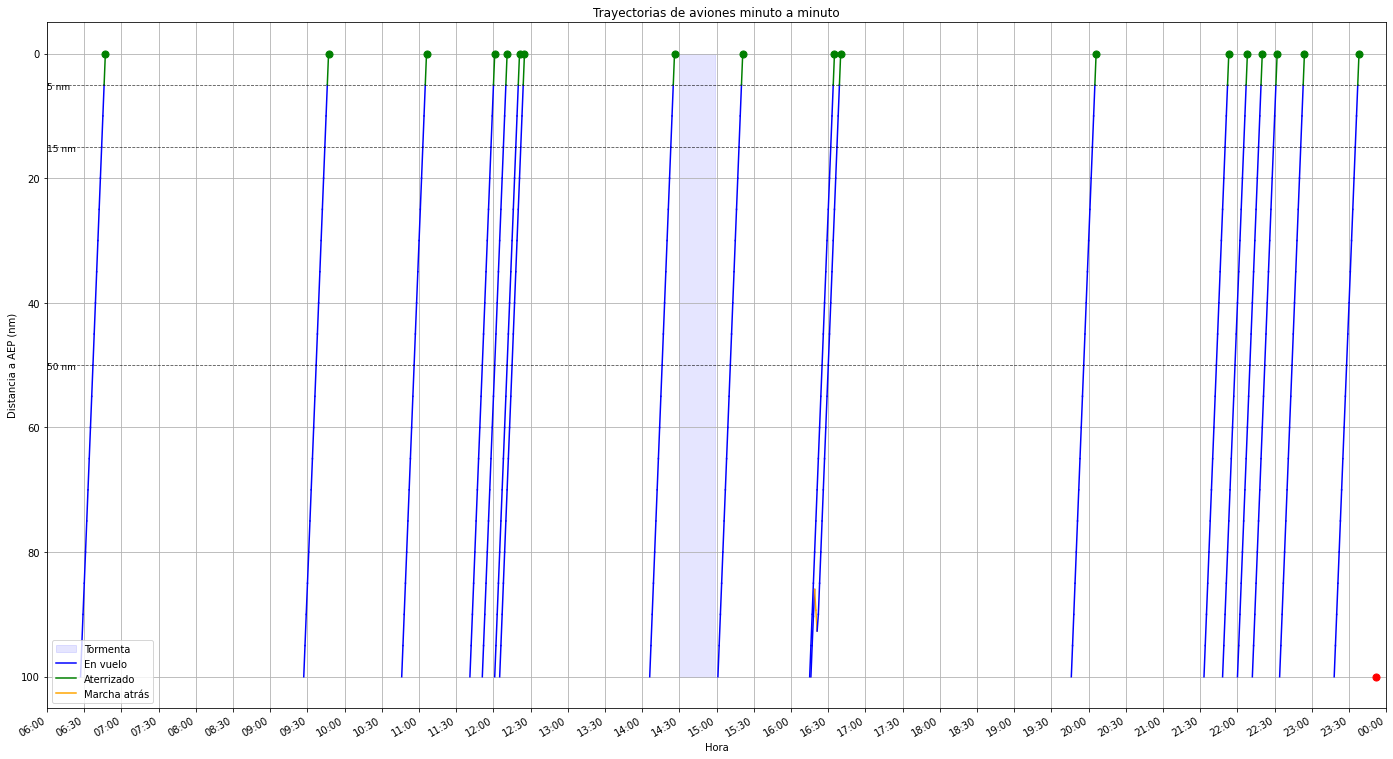

In [6]:
visualizar_trayectorias_horas(res, hora_final=timepo, tormenta=1)

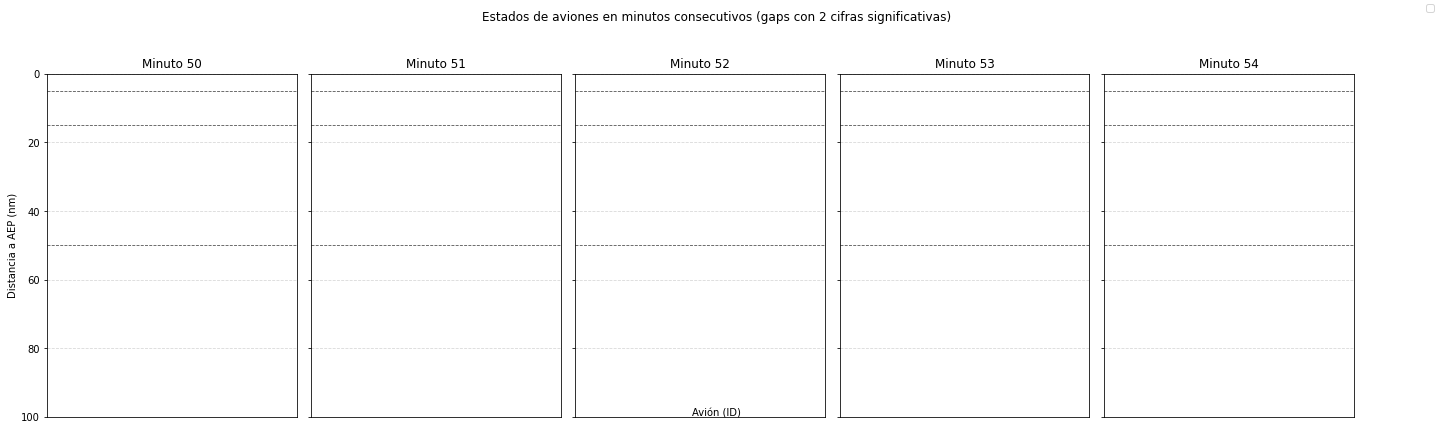

In [7]:
visualizar_estados_en_rango(res, 50, cantidad=5)


## 2. Cálculo de λ para 1 avión por hora

Si el promedio de arribos es de 1 avión por hora, determinar el valor de λ.


In [8]:
# Código: cálculo de λ


## 3. Probabilidad de llegada de 5 aviones en una hora

- Usar simulación de Monte Carlo para estimar la probabilidad.  
- Verificar el resultado de manera analítica con la distribución de Poisson.


In [9]:
# Código: simulación para estimar probabilidad


In [10]:
# Código: verificación analítica usando Poisson


## 4. Congestión según distintos λ

Simular el sistema con λ ∈ {0.02, 0.1, 0.2, 0.5, 1}.  
Analizar:
- Frecuencia de congestión.  
- Atraso promedio de los aviones.  
- Frecuencia de desvíos a Montevideo.  
- Acompañar cada resultado con estimación de error.  
- Mostrar visualizaciones gráficas.


In [11]:
# Código: simulación para distintos λ


In [12]:
# Código: métricas de congestión y atrasos


In [13]:
# Código: visualización comparativa


## 5. Escenario con día ventoso

Cada avión tiene 1/10 de probabilidad de tener que interrumpir su aterrizaje.  
Se debe simular:
- Estadísticas de atrasos en función de λ.  
- Desvíos a Montevideo.  
- Visualización de aviones (incluyendo los que se desvían).  
- Estimación de errores.


In [14]:
# Código: simulación con interrupciones (día ventoso)


In [15]:
# Código: métricas de performance bajo viento


In [16]:
# Código: visualización de interrupciones y desvíos


## 6. Escenario con tormenta

Si AEP cierra sorpresivamente por 30 minutos:  
- Calcular consecuencias en desvíos, atrasos y otras métricas en función de λ.  
- Comparar con escenarios normales.


In [17]:
# Código: simulación con cierre sorpresivo


In [18]:
# Código: métricas y comparación con caso base


## 7. Políticas de vuelo alternativas

Explorar políticas simples basadas en información contemporánea (posiciones y velocidades actuales) para:  
- Reducir atrasos.  
- Disminuir o eliminar desvíos a Montevideo.  
- Analizar trade-off entre atraso promedio y frecuencia de desvíos.


In [19]:
# Código: implementación de políticas alternativas


## 8. Conclusiones

- Resumen de los principales hallazgos.  
- Comparación entre distintos escenarios de λ, viento y tormenta.  
- Discusión sobre posibles mejoras de políticas de control aéreo.


In [20]:
# (Opcional) Gráficos finales comparativos / resumen visual
